In [1]:
import os
import numpy as np
import pickle
import matplotlib.pyplot as plt
from datetime import datetime
import random

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Lambda, Concatenate, BatchNormalization
from tensorflow.keras.layers import Input, Add, Conv2D, MaxPooling2D, AveragePooling2D, Softmax, InputLayer
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint
from keras import backend as K

# set random seed value for reproducable results
seed_value= 4815
os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

print(f"tf version: {tf.__version__}")
print("GPUs: ", tf.config.list_physical_devices('GPU'))

2022-09-29 18:49:03.195430: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-29 18:49:03.398146: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-09-29 18:49:03.469240: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-09-29 18:49:04.239127: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: li

tf version: 2.10.0
GPUs:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2022-09-29 18:49:05.296302: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-09-29 18:49:05.350499: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-09-29 18:49:05.350532: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [2]:
EPOCHS = 50
BATCH_SIZE_TRAIN = 64
VALIDATION = True

# load data

In [3]:
data_path = "data/"
train_path = data_path + "train2014/train2014"
val_path = data_path + "val2014/val2014"

with open(os.path.join(train_path +"_processed.pickle"), "rb") as f:
    training_data = pickle.load(f)
len_training_data_raw = len(training_data)

with open(os.path.join(val_path + "_processed.pickle"), "rb") as f:
    validation_data = pickle.load(f)

training_data = training_data[:len(training_data) // BATCH_SIZE_TRAIN * BATCH_SIZE_TRAIN]
print(f"number training data: {len(training_data)}")
print("batch_size_train: " + str(BATCH_SIZE_TRAIN))
if VALIDATION:
    # batch_size_val = int(BATCH_SIZE_TRAIN * (len(validation_data) / (len_training_data_raw + len(validation_data))))
    batch_size_val = BATCH_SIZE_TRAIN
    validation_data = validation_data[:len(validation_data) // batch_size_val * batch_size_val]
    print(f"number validation data: {len(validation_data)}")
    print(f"batch_size_val: {batch_size_val}")

number training data: 78720
batch_size_train: 64
number validation data: 38528
batch_size_val: 64


# construct network

In [4]:
def homography_net():
    input_shape = (128, 128, 2)
    kernel_size = 3
    pool_size = 2
    filters = 64
    dropout = 0.5

    model = Sequential()
    model.add(InputLayer(input_shape))
    model.add(Conv2D(filters=filters,\
            kernel_size=kernel_size, activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(filters=filters,\
            kernel_size=kernel_size, activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size))
    model.add(Conv2D(filters=filters,\
            kernel_size=kernel_size, activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(filters=filters,\
            kernel_size=kernel_size, activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size))
    model.add(Conv2D(filters=filters*2,\
            kernel_size=kernel_size, activation='relu', padding='same',))
    model.add(BatchNormalization())
    model.add(Conv2D(filters=filters*2,\
            kernel_size=kernel_size, activation='relu', padding='same',))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size))
    model.add(Conv2D(filters=filters*2,\
            kernel_size=kernel_size, activation='relu', padding='same',))
    model.add(BatchNormalization())
    model.add(Conv2D(filters=filters*2,\
            kernel_size=kernel_size, activation='relu', padding='same',))
    model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Dropout(dropout))
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(dropout))
    model.add(Dense(8))
    return model

model = homography_net()
sgd = tf.optimizers.SGD(learning_rate=0.005, momentum=0.9)

def euclidean_l2(y_true, y_pred):
    return K.sqrt(K.sum(K.square(y_pred - y_true), axis=-1, keepdims=True))
model.compile(optimizer=sgd, loss=euclidean_l2, metrics=['mean_squared_error'])

print(model.summary())

2022-09-29 18:49:26.019327: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-29 18:49:26.021199: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-09-29 18:49:26.021269: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-09-29 18:49:26.021282: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been bu

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 64)      1216      
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 64)     256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      36928     
                                                                 
 batch_normalization_1 (Batc  (None, 128, 128, 64)     256       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 64)       0         
 )                                                               
                                                        

# train network

In [5]:
model_path = "model"

# generator for model.fit()
def generate(batch_size, s='train'):
    batch_index = 0
    while True:
        if s == 'train':
            data = training_data
        elif s == 'val':
            data = validation_data
        else:
            print('check operation mode parameter')
            return None

        batch_x, batch_y = [], []
        for i in range(batch_size):
            index = batch_index + i
            if index >= len(data):
                print("WARNING: check if batch size is factor of data size")
                index = index % len(data)
            batch_x.append((data[index][0].astype(float) - 127.5) / 127.5)
            batch_y.append(data[index][1].astype(float).flatten())
        
        batch_x = np.asarray(batch_x)
        batch_y = np.asarray(batch_y)

        yield batch_x, batch_y
        batch_index += batch_size

        # reset batch_index if next epoch
        if s=='train' and batch_index >= len(training_data):
            batch_index = 0
        elif s=='val' and batch_index >= len(validation_data):
            batch_index = 0

if VALIDATION:
    history = model.fit(generate(BATCH_SIZE_TRAIN, s='train'), epochs=EPOCHS, steps_per_epoch = len(training_data)//BATCH_SIZE_TRAIN, validation_data = generate(batch_size_val, s='val'), validation_steps = len(validation_data)//batch_size_val)
else:
    history = model.fit(generate(BATCH_SIZE_TRAIN, s='train'), epochs=EPOCHS, steps_per_epoch = len(training_data)//BATCH_SIZE_TRAIN)

current_time = datetime.now().strftime("%H_%M_%S")
model.save(model_path + "/model_" + current_time, save_format='tf')

Epoch 1/50


2022-09-29 18:49:28.864331: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8500
2022-09-29 18:49:30.184500: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


1230/1230 [==============================] - 171s 135ms/step - loss: 0.8591 - mean_squared_error: 0.1879 - val_loss: 0.5591 - val_mean_squared_error: 0.0504
Epoch 2/50
1230/1230 [==============================] - 164s 133ms/step - loss: 0.6338 - mean_squared_error: 0.0629 - val_loss: 0.4916 - val_mean_squared_error: 0.0386
Epoch 3/50
1230/1230 [==============================] - 161s 131ms/step - loss: 0.5822 - mean_squared_error: 0.0538 - val_loss: 0.4526 - val_mean_squared_error: 0.0325
Epoch 4/50
1230/1230 [==============================] - 161s 131ms/step - loss: 0.5335 - mean_squared_error: 0.0460 - val_loss: 0.4066 - val_mean_squared_error: 0.0279
Epoch 5/50
1230/1230 [==============================] - 161s 131ms/step - loss: 0.4853 - mean_squared_error: 0.0390 - val_loss: 0.3701 - val_mean_squared_error: 0.0241
Epoch 6/50
1230/1230 [==============================] - 161s 131ms/step - loss: 0.4393 - mean_squared_error: 0.0329 - val_loss: 0.3255 - val_mean_squared_error: 0.0192
Epo

INFO:tensorflow:Assets written to: model/model_21_06_03/assets


INFO:tensorflow:Assets written to: model/model_21_06_03/assets


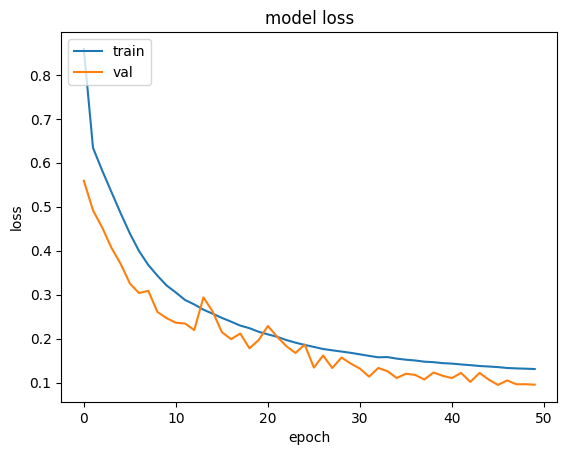

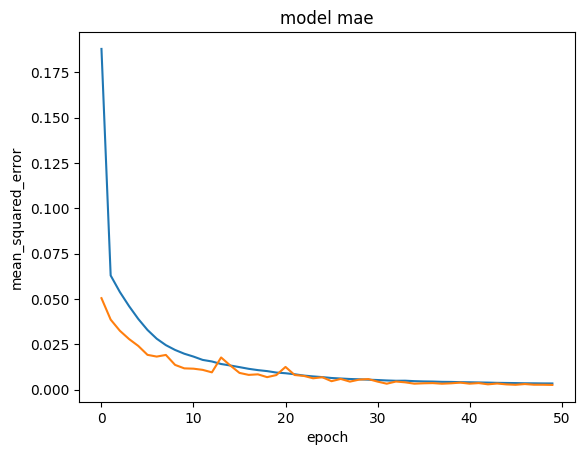

In [6]:
plt.plot(history.history['loss'])
if VALIDATION:
    plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# visualize mse
plt.plot(history.history['mean_squared_error'])
if VALIDATION:
    plt.plot(history.history['val_mean_squared_error'])
plt.title('model mae')
plt.ylabel('mean_squared_error')
plt.xlabel('epoch')
plt.show()